In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
import autorootcwd
import torch
import madmom
import os
from madmom.features.beats import RNNBeatProcessor, DBNBeatTrackingProcessor

In [17]:
# Functions
def get_filenames(dir: str = "data/processed/audio") -> list:
    """
    Get a list of filenames in a directory.

    Args:
        directory (str): The directory to get the filenames from.

    Returns:
        filenames (list): A list of filenames in the directory.
    """
    filenames = os.listdir(dir)
    filenames = [
        filename.split(".")[0] for filename in filenames if filename.endswith(".mp3")
    ]
    return filenames

Detected beats (seconds): [1.7000e-01 5.7000e-01 9.9000e-01 1.3800e+00 1.7800e+00 2.1900e+00
 2.5800e+00 2.9700e+00 3.3700e+00 3.7800e+00 4.1900e+00 4.5800e+00
 4.9800e+00 5.3900e+00 5.7900e+00 6.1900e+00 6.5700e+00 6.9800e+00
 7.3900e+00 7.7900e+00 8.1800e+00 8.5900e+00 8.9800e+00 9.3700e+00
 9.7600e+00 1.0150e+01 1.0560e+01 1.0950e+01 1.1360e+01 1.1750e+01
 1.2140e+01 1.2540e+01 1.2930e+01 1.3310e+01 1.3700e+01 1.4080e+01
 1.4450e+01 1.4840e+01 1.5230e+01 1.5630e+01 1.6030e+01 1.6410e+01
 1.6780e+01 1.7160e+01 1.7530e+01 1.7930e+01 1.8310e+01 1.8680e+01
 1.9060e+01 1.9450e+01 1.9820e+01 2.0200e+01 2.0580e+01 2.0970e+01
 2.1350e+01 2.1720e+01 2.2090e+01 2.2480e+01 2.2860e+01 2.3230e+01
 2.3600e+01 2.3980e+01 2.4350e+01 2.4700e+01 2.5070e+01 2.5440e+01
 2.5830e+01 2.6200e+01 2.6570e+01 2.6950e+01 2.7330e+01 2.7690e+01
 2.8070e+01 2.8450e+01 2.8820e+01 2.9190e+01 2.9570e+01 2.9950e+01
 3.0320e+01 3.0690e+01 3.1060e+01 3.1430e+01 3.1820e+01 3.2190e+01
 3.2570e+01 3.2940e+01 3.3330e+01 3.

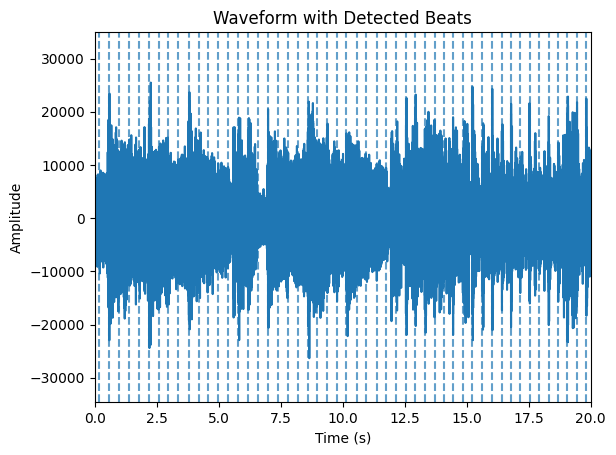

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# madmom utility to load audio
from madmom.audio.signal import Signal

# 1. RNNBeatProcessor -> beat activation
from madmom.features.beats import RNNBeatProcessor
# 2. DBNBeatTrackingProcessor -> actual beat times
from madmom.features.beats import DBNBeatTrackingProcessor

# Example file
# 2. Run the processor on an audio file (MP3 or WAV).
fname = get_filenames()[0]
audio_path = f'./data/processed/audio/{fname}.mp3'

# --- STEP A: load audio for plotting ---
# Set num_channels=1 to ensure a single channel (mono)
# sample_rate is auto-detected from the file
signal = Signal(audio_path, num_channels=1)

# We'll extract the raw audio samples and the sample rate
audio_samples = signal
sr = signal.sample_rate

# Prepare a time axis for plotting, in seconds
times = np.arange(len(audio_samples)) / float(sr)

# --- STEP B: process for beats ---
# Create the processor objects
act_proc = RNNBeatProcessor()  # or specify your own model path if needed
beat_proc = DBNBeatTrackingProcessor(fps=100)

# Extract activations
activations = act_proc(audio_path)
# Convert activations to beat timestamps (in seconds)
beats = beat_proc(activations)
print("Detected beats (seconds):", beats)

# --- STEP C: plot waveform + beats ---
plt.figure()

# Plot the waveform over time
plt.plot(times, audio_samples, label="Audio waveform")

# Overlay a vertical line at each beat time
for b in beats:
   plt.axvline(x=b, linestyle='--', alpha=0.7)  # no color specified

plt.title("Waveform with Detected Beats")
plt.xlim(0, 20)  # Set x-axis limits to the length of the audio
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [29]:
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
from madmom.features.beats import RNNBeatProcessor, DBNBeatTrackingProcessor
import os
from pathlib import Path

import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

from madmom.features.beats import RNNBeatProcessor, DBNBeatTrackingProcessor


def process_audio_file(audio_path_str):
    act_proc = RNNBeatProcessor()
    beat_proc = DBNBeatTrackingProcessor(fps=100)
    activations = act_proc(audio_path_str)
    beats = beat_proc(activations)
    return beats

def get_beats_for_audio_directory(directory_path, n_jobs=4):
    """
    Processes all .mp3 files in `directory_path` in parallel and extracts the beat times.
    Returns:
        dict: A dictionary mapping { audio_filename: list_of_beat_times_in_seconds }.
    """
    audio_files = sorted(Path(directory_path).glob("*.mp3"))
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_audio_file)(str(audio_file)) 
        for audio_file in tqdm(audio_files, desc="Processing audio files", total=len(audio_files))
    )
    
    return {file.name: beats for file, beats in zip(audio_files, results)}

def estimate_bpm(beats):
    """
    Given a list (or np.array) of beat times in seconds, 
    estimate BPM (Beats Per Minute) by computing the average interval between beats.
    
    Returns:
        float: Estimated BPM.
    """
    if len(beats) < 2:
        return 0.0
    
    # Calculate the intervals (in seconds) between consecutive beats
    intervals = np.diff(beats)
    
    # Compute average interval
    avg_interval = np.mean(intervals)
    
    # BPM is 60 / average interval in seconds
    estimated_bpm = 60.0 / avg_interval
    
    return estimated_bpm

In [31]:
dir = "data/processed/audio"
# Get all beats for the directory
all_beats = get_beats_for_audio_directory(dir, n_jobs=4)

KeyboardInterrupt: 

In [24]:
# Get chord annotation
from src.utils import get_raw_chord_annotation

# Get the chord annotation
chord_annotation = get_raw_chord_annotation(fname)
print("Chord annotation:", chord_annotation)

AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.